In [2]:
# Texas Real Estate Trends

In [3]:
## Importing Libraries

In [4]:
import pandas as pd

In [5]:
## Loading Data

In [6]:
df = pd.read_csv("real_estate_texas_500_2024.csv")

# will display the first few rows
df.head()

,url,status,id,listPrice,baths,baths_full,baths_full_calc,beds,sqft,stories,sub_type,text,type,year_built
0,https://www.realtor.com/realestateandhomes-det...,for_sale,9773941616,240000.0,2,2.0,2.0,3.0,1190.0,1.0,NaN,Welcome home to your peaceful retreat nestled ...,single_family,2018.0
1,https://www.realtor.com/realestateandhomes-det...,for_sale,9224923922,379900.0,4,3.0,3.0,4.0,2033.0,1.0,NaN,"Beautiful country home on 0.85 fenced acres, m...",single_family,2002.0
2,https://www.realtor.com/realestateandhomes-det...,for_sale,9840661824,370000.0,2,2.0,2.0,4.0,2062.0,1.0,NaN,PRICED TO SELL CORNER LOT HAS A STORM SHELTER ...,single_family,2012.0
3,https://www.realtor.com/realestateandhomes-det...,for_sale,7338317229,444000.0,4,3.0,3.0,5.0,3705.0,2.0,NaN,Come check out country living in the city! Are...,single_family,1985.0
4,https://www.realtor.com/realestateandhomes-det...,for_sale,7285845528,569000.0,2,2.0,2.0,3.0,3282.0,2.0,NaN,Welcome to your dream retreat! Nestled on over...,single_family,1981.0


In [7]:
# trying to figure out how many rows and columns
df.shape

(501, 14)

In [8]:
# column names, data types, missing info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501 entries, 0 to 500
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   url              501 non-null    object 
 1   status           501 non-null    object 
 2   id               501 non-null    int64  
 3   listPrice        499 non-null    float64
 4   baths            501 non-null    int64  
 5   baths_full       436 non-null    float64
 6   baths_full_calc  436 non-null    float64
 7   beds             440 non-null    float64
 8   sqft             438 non-null    float64
 9   stories          391 non-null    float64
 10  sub_type         10 non-null     object 
 11  text             495 non-null    object 
 12  type             501 non-null    object 
 13  year_built       289 non-null    float64
dtypes: float64(7), int64(2), object(5)
memory usage: 54.9+ KB


In [9]:
# checking for the sum of null values in each column
df.isnull().sum()

url                  0
status               0
id                   0
listPrice            2
baths                0
baths_full          65
baths_full_calc     65
beds                61
sqft                63
stories            110
sub_type           491
text                 6
type                 0
year_built         212
dtype: int64

In [10]:
!python3 -m pip install seaborn


[notice] A new release of pip is available: 23.3.1 -> 25.0.1
[notice] To update, run: pip3 install --upgrade pip


In [11]:
!pip show seaborn

Name: seaborn
Version: 0.13.2
Summary: Statistical data visualization
Home-page: 
Author: 
Author-email: Michael Waskom <mwaskom@gmail.com>
License: 
Location: /opt/homebrew/lib/python3.11/site-packages
Requires: matplotlib, numpy, pandas
Required-by: 


In [12]:
import sys
print(sys.executable)

/Library/Frameworks/Python.framework/Versions/3.12/bin/python3


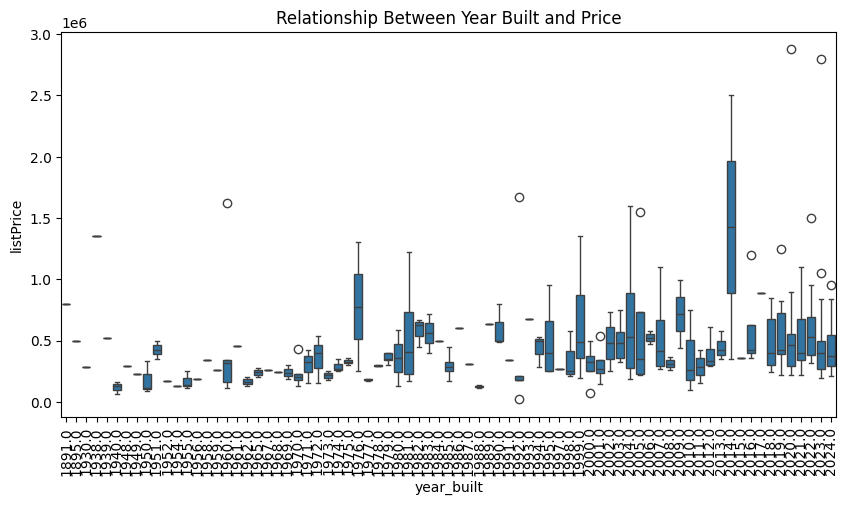

In [13]:
# realized from this that sub_type is almost entirely missing, and year_built almost. can drop sub_type, but need to check if year_built is important enough to save
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5)) # just an estimate of what will make the plot wide enough and easy to read
sns.boxplot(x=df["year_built"], y=df["listPrice"]) # good for visualizing distribution of num data across different categories (good with outliers, shows distribution, easy to compare)
plt.xticks(rotation=90) # years can be close together, can rotate to make more readable
plt.title("Relationship Between Year Built and Price")
plt.show()

In [14]:
# boxplot shows that year_built does matter in determining price, but we have 212 missing values, so what do we do?
# can use the mode of the year for the missing values

df["year_built"].mode()

0    2024.0
Name: year_built, dtype: float64

In [15]:
# comparing to see which one will work better for this situation
print("Mode:", df["year_built"].mode()[0])
print("Median:", df["year_built"].median())

Mode: 2024.0
Median: 2006.0


In [16]:
# from this we can tell hat the mode not trustworthy, its the current year, so we'll go with median
df["year_built"].isnull().sum()

212

In [17]:
# Fill missing numerical values with the median
df["beds"].fillna(df["beds"].median(), inplace=True)
df["baths_full"].fillna(df["baths_full"].median(), inplace=True)
df["sqft"].fillna(df["sqft"].median(), inplace=True)
df["stories"].fillna(df["stories"].median(), inplace=True)

In [18]:
# Check for any remaining missing values
df.isnull().sum()

url                  0
status               0
id                   0
listPrice            2
baths                0
baths_full           0
baths_full_calc     65
beds                 0
sqft                 0
stories              0
sub_type           491
text                 6
type                 0
year_built         212
dtype: int64

In [19]:
# List all column names
print(df.columns)

Index(['url', 'status', 'id', 'listPrice', 'baths', 'baths_full',
       'baths_full_calc', 'beds', 'sqft', 'stories', 'sub_type', 'text',
       'type', 'year_built'],
      dtype='object')


In [20]:
# missing too many things
# Drop column only if it exists
if "sub_type" in df.columns:
    df.drop(columns=["sub_type"], inplace=True)

# filling again
df["year_built"].fillna(df["year_built"].median(), inplace=True)
df["listPrice"].fillna(df["listPrice"].median(), inplace=True)
df["baths_full_calc"].fillna(df["baths_full"], inplace=True)

# handle text
df["text"].fillna("No description available", inplace=True)

df.isnull().sum()

url                0
status             0
id                 0
listPrice          0
baths              0
baths_full         0
baths_full_calc    0
beds               0
sqft               0
stories            0
text               0
type               0
year_built         0
dtype: int64

In [22]:
# next we need to figure out outliers
Q1 = df["listPrice"].quantile(0.25)
Q3 = df["listPrice"].quantile(0.75)
IQR = Q3 - Q1

# Define outlier threshold
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
outliers = df[(df["listPrice"] < lower_bound) | (df["listPrice"] > upper_bound)]
print("Number of outliers detected:", outliers.shape[0])

Number of outliers detected: 30
